These are all the imports from python libraries and landlab components

In [73]:
import numpy as np
import matplotlib.pyplot as plt #For plotting results; optional

## Import Landlab components
#Pit filling; optional
from landlab.components import DepressionFinderAndRouter
#Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator instead of FlowRouter--- router is a deprecated component for landlab
#from landlab.components.flow_accum.flow_accumulator import FlowAccumulator
from landlab.components import PriorityFloodFlowRouter
#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import FastscapeEroder 

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results; optional
from landlab.io import read_esri_ascii
%matplotlib inline

This section is for setting up the parameters of the Raster Model grid

In [74]:
#Set grid parameters
num_rows = 20
num_columns = 20
node_next_to_outlet = num_columns+1
node_spacing = 100.0

#Set model timestep
timestep = 1.0 #years

#Set model run time
run_time = 500 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)
#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')
#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)


## Create initial model topography
#plane tilted towards the lower−left corner
topo = mg.node_y/100000 + mg.node_x/100000

#topographic roughness
random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid
mg['node']['topographic__elevation'] += (topo + random_noise) 

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')


#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation'
#to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] 
mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']


This section is to set the boundaries of the grid

In [75]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                       left_is_closed=True,
                                       right_is_closed=True,
                                       top_is_closed=True)

#Set lower-left (southwest) corner as an open boundary
mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)


In [76]:
#Instantiate flow router
fr = FlowAccumulator(mg, flow_director='D8')        #changed this to FlowAccumulator
#flow_director='D8' was previously a parameter of the above function call
#Instantiate depression finder and router; optional
df = DepressionFinderAndRouter(mg)
#fr = PriorityFloodFlowRouter(mg, separate_hill_flow = True, suppress_out = True)

#Instantiate SPACE model with chosen parameters    , method='simple_stream_power'
sp = Space(mg, K_sed=0.01, K_br=0.001, F_f=0., phi=0., H_star=1., v_s=5.0, m_sp=0.5, n_sp=1.0, sp_crit_sed=0, sp_crit_br=0)

In [77]:

#Set elapsed time to zero
elapsed_time = 0 #years





#Set timestep count to zero
count = 0

#Array to save sediment flux values
#sed_flux = np.zeros(int(run_time // timestep))
sed_flux = [0] * int(500)                                       ###added this instead of the previous line
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'] += uplift_per_timestep 
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth']
    
    #Run the flow router
    fr.run_one_step()
    
    #Run the depression finder and router; optional
    df.map_depressions()
    
    #Get list of nodes in depressions; only
    #used if using DepressionFinderAndRouter
    flooded = np.where(df.flood_status==3)[0]
    sp.run_one_step(dt = timestep) #had to delete flooded_nodes=flooded
    #print(mg.at_node['sediment__flux'])
    #temp = mg.at_node['sediment__flux'][:]
    #temp = sum(mg.at_node['sediment__flux'][:])
    #sed_flux[count] = temp
    #print(sed_flux[count])

    #sed_flux[:] = mg.at_node['sediment__flux']

    #sed_flux[count] = mg.at_node['topographic__elevation']
    #Save sediment flux value to array
    sed_flux[count] = mg.at_node['sediment__flux'][node_next_to_outlet]
    #Add to value of elapsed time
    elapsed_time += timestep
    
    #Increase timestep count
    count += 1

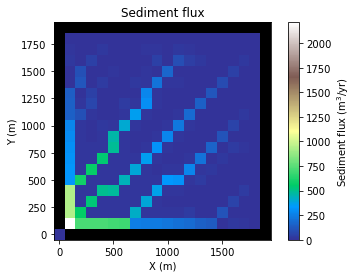

In [78]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='terrain')

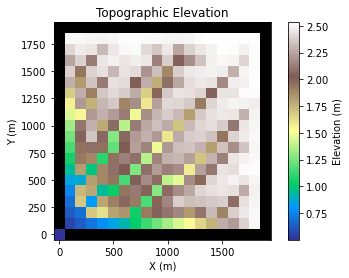

In [79]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

In [80]:
#Export figure to image
fig.savefig('sediment_flux_map.eps')

Text(0, 0.5, 'Sediment flux [m$^3$/yr]')

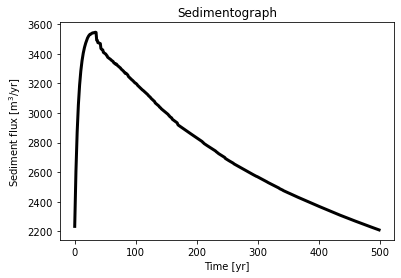

In [81]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
sedfluxplot = plt.subplot()

#Plot data
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3) ###Changed the arange(_) value from 500 to 400
#Add axis labels
sedfluxplot.set_title('Sedimentograph')
sedfluxplot.set_xlabel('Time [yr]')
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]')

In [82]:
#Export figure to image
fig.savefig('sedimentograph.eps')